## import
匯入所需程式庫，用於資料處理、科學計算、資料視覺化和深度學習


In [1]:
#必要程式庫
import pandas as pd
import numpy as np
import random
import os
# 資料視覺化
import matplotlib.pyplot as plt
import plotly.express as px

# 深度學習架構
import torch
import torch.nn as nn

# 將資料集分成訓練集和測試集。
from sklearn.model_selection import train_test_split
# 用於計算準確度分數與F1分數，一種常用的分類模型評估指標。
from sklearn.metrics import accuracy_score, f1_score 

設定模型訓練時的一些參數

In [2]:
class config:
    # 資料路徑
    root = "/kaggle/input/hw1-data"
    # 批次大小
    batch_size = 16
    #學習率
    lr = 1e-3
    #訓練總epoches數
    epoches = 120
    #設定權重衰減
    weight_decay = 1e-2
    #根據是否有CUDA可用，選擇運行裝置為cuda或cpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #設定隨機種子，重現實驗結果
    seed = 42

隨機種子的設定，可以確保在不同運行中得到相同的隨機結果，有助於實驗的可重複性和比較不同模型、參數設定下的效果

In [3]:
def seed_everything(seed):
    #設定python隨機種子
    random.seed(seed)
    
    #設定NumPy隨機種子
    np.random.seed(seed)
    
    #設定PyTorch的隨機種子（CPU和GPU）
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
    #設定PyTorch的cudnn後端為 deterministic mode
    torch.backends.cudnn.deterministicdete = True
    torch.backends.cudnn.benchmark = False

讀取資料集
透過 pd.read_csv 函式來讀取CSV格式的資料集。os.path.join 函式用於組合路徑，將設定中的資料根目錄 (config.root) 與檔案名稱結合，形成完整的檔案路徑。

In [4]:
train_data = pd.read_csv(os.path.join(config.root,'zip.train1.csv'),header = None)
test_data = pd.read_csv(os.path.join(config.root,'zip.test1.csv'),header = None)

#顯示訓練集內容
train_data
#test_data

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,6,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,...,0.304,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0
1,5,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0
2,4,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0
3,7,-1.0,-1.0,-1.0,-1.000,-1.000,-0.273,0.684,0.960,0.450,...,-0.318,1.000,0.536,-0.987,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
4,3,-1.0,-1.0,-1.0,-1.000,-1.000,-0.928,-0.204,0.751,0.466,...,0.466,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7286,3,-1.0,-1.0,-1.0,-0.988,-0.527,-0.208,0.620,1.000,0.467,...,-0.116,0.899,0.416,-0.510,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
7287,3,-1.0,-1.0,-1.0,-0.990,0.708,0.557,0.347,-0.107,-0.758,...,0.697,0.636,0.167,-0.968,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
7288,3,-1.0,-1.0,-1.0,-0.783,-0.984,-0.827,0.068,1.000,1.000,...,0.805,1.000,1.000,0.727,-0.342,-0.933,-1.000,-1.000,-1.000,-1.0
7289,0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.549,0.463,0.999,0.999,...,-0.231,0.621,0.999,-0.042,-0.231,-0.687,-1.000,-1.000,-1.000,-1.0


顯示 train_data 的基本統計資訊，如數量、平均值、標準差、最小值、25th、50th（中位數）、75th百分位數以及最大值等。幫助了解資料的分佈和特徵。

In [5]:
#獲取train_data的基本統計資訊
train_data.describe()


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
count,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,...,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000
mean,3.903443,-0.996417,-0.981138,-0.951153,-0.887738,-0.773468,-0.610302,-0.368991,-0.045769,-0.052641,...,-0.198547,0.139823,0.116439,-0.314108,-0.653711,-0.837858,-0.922194,-0.957393,-0.979290,-0.994678
std,2.996386,0.051713,0.151202,0.244264,0.360516,0.502659,0.628710,0.716032,0.768304,0.752979,...,0.772895,0.752984,0.757336,0.725859,0.582555,0.414646,0.300830,0.228700,0.158998,0.066056
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999000,-0.950000,...,-1.000000,-0.661500,-0.738000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,4.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.719000,0.061000,0.002000,...,-0.353000,0.368000,0.336000,-0.579000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,7.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.962000,-0.391000,0.254500,0.696000,0.674500,...,0.554000,0.835000,0.815000,0.346000,-0.504500,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,9.000000,0.638000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.592000


顯示訓練集和測試集的樣本數量

In [6]:
print(f"Number of training sample:{train_data.shape[0]}")
print(f"Number of testing sample:{test_data.shape[0]}")

Number of training sample:7291
Number of testing sample:2007


+ iloc 方法選取訓練集中的第一列（標籤列）<br>
+ value_counts() 方法計算各個不同值的出現次數<br>
+ sort_index() 方法按照索引（即標籤值）排序

In [7]:
#計算第一列(0~9 label)中各個值的出現次數，並按照索引排序
train_data.iloc[:, 0].value_counts().sort_index()

0
0    1194
1    1005
2     731
3     658
4     652
5     556
6     664
7     645
8     542
9     644
Name: count, dtype: int64

### 創建並顯示訓練集中不同標籤的樣本分佈

In [8]:
# 計算訓練集中每個標籤的樣本數量
train_label_distribution = train_data.iloc[:, 0].value_counts().sort_index()
# 創建一個DataFrame，包含標籤和對應的樣本數量
train_label_distribution = pd.DataFrame(
{
    "labels": train_label_distribution.index.astype(str),
    "number of samples": train_label_distribution.values
})
# 使用plotly創建條形圖
fig = px.bar(train_label_distribution, x="labels",y="number of samples",labels = dict(y="number of samples"),
            )
# 更新圖表的外觀設定
fig.update_layout(plot_bgcolor='white',
                  xaxis = dict(showgrid=True,gridcolor ='lightgray',zeroline=False),
                  yaxis = dict(showgrid=True,gridcolor ='lightgray',zeroline=False),
                  title = dict(text="number of samples per labels",x=0.5,y=0.975,font=dict(size=20))
                             )  
fig.show()

### Pytorch Dataset

#### 處理手寫數字資料集

In [9]:
class HandwrittenDigits(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        """
        初始化函式，設定資料集和轉換。
        Parameters:
            df (DataFrame): 包含手寫數字資料的DataFrame。
            transforms (callable, optional): 資料轉換函式，用於對資料進行轉換。預設為None。
        """
        self.df = df
        self.transforms = transforms
        
    def __getitem__(self,x):
        """
        獲取指定索引的資料和標籤。
        
        Parameters:
            x (int): 資料的索引。
            
        Returns:
            torch.Tensor: 圖像的張量表示。
            torch.Tensor: 標籤的張量表示。
        """
        image, label = self.df.iloc[x,1:].to_numpy(),self.df.iloc[x,0]
        image, label = torch.tensor(image),torch.tensor(label)
        return image,label
    
    def __len__(self):
        """
        獲取資料集的總樣本數量。
        
        Returns:
            int: 資料集的總樣本數量。
        """
        return self.df.shape[0]
    
    

In [10]:
class testDataDigit(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        
        self.df = df
        self.transforms = transforms
        
    def __getitem__(self,x):
     
        image = self.df.iloc[x,:].to_numpy()
        image = torch.tensor(image)
        return image
    
    def __len__(self):
        return self.df.shape[0]

In [11]:
ds = HandwrittenDigits(train_data)
ds[0]# 獲取第一個樣本的資料和標籤

(tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.6310,
          0.8620, -0.1670, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9920,  0.2970,
          1.0000,  0.3070, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.4100,  1.0000,
          0.9860, -0.5650, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.6830,  0.8250,  1.0000,
          0.5620, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -0.9380,  0.5400,  1.0000,  0.7780,
         -0.7150, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000,  0.1000,  1.0000,  0.9220, -0.4390,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

根據資料集的大小及設定，劃分成訓練集、驗證集和測試集的索引

In [12]:
def split_ids(n,train_size,val_size,test_size):
    """
    根據指定的訓練集、驗證集和測試集的比例，劃分資料集的索引。
    
    Parameters:
        n (int): 資料集的大小（樣本數）。
        train_size (float): 訓練集的比例。
        val_size (float): 驗證集的比例。
        test_size (float): 測試集的比例。
        
    Returns:
        numpy.ndarray: 訓練集的索引。
        numpy.ndarray: 測試集的索引。
        numpy.ndarray: 驗證集的索引。
    """
    # 計算各集合的大小
    train_size = int(train_size * n)
    val_size = int(val_size * n)
    test_size = int(test_size * n)
    # 將資料集索引切分為訓練集和測試集
    train_indices, test_indices = train_test_split(np.linspace(0,n-1,n).astype("int"),test_size =test_size,random_state = 42,)
    # 將訓練集進一步切分為訓練集和驗證集
    train_indices, val_indices = train_test_split(train_indices, test_size = test_size, random_state=42)
    return train_indices, test_indices, val_indices

### Pytorch DataLoader


建立了訓練、驗證和測試的資料集以及資料載入器，並將資料集分割成訓練、驗證和測試集合。

In [13]:
# 創建HandwrittenDigits資料集的實例，傳入訓練集train_data
dataset = HandwrittenDigits(train_data)
# 使用split_ids將資料集分割為訓練、驗證和測試集合
train_ids, val_ids, test_ids = split_ids(train_data.shape[0],0.8, 0.1, 0.1)
# 根據分割得到的索引創建子集資料集
train_dataset = torch.utils.data.Subset(dataset,train_ids)
val_dataset = torch.utils.data.Subset(dataset,val_ids)
test_dataset = torch.utils.data.Subset(dataset,test_ids)

# 創建資料載入器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = config.batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = config.batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = config.batch_size,shuffle=False)

從訓練資料載入器中獲取一個 batch 的資料，並顯示前16張圖像及其標籤。接著刪除 images 和 labels 變數以釋放記憶體。

Image shape: torch.Size([16, 256]),label shapetorch.Size([])


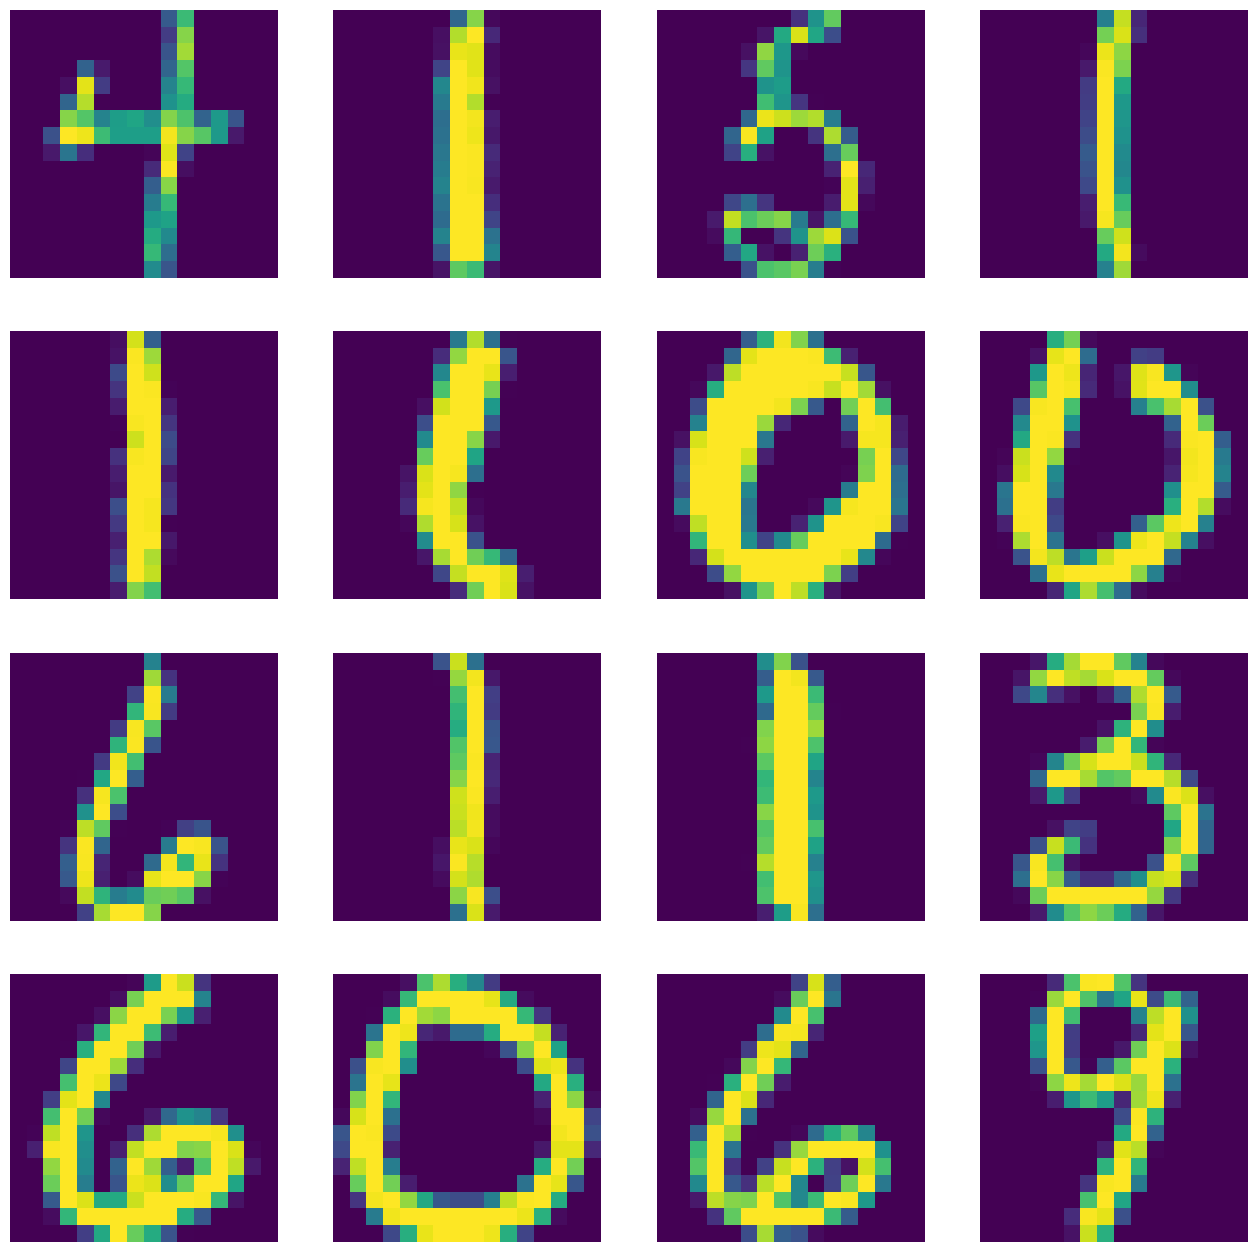

In [14]:
# 從訓練資料載入器中獲取一個 batch 的資料
images, labels = next(iter(train_loader))
images, labels = images[:16], labels[:16]
# 設定圖像顯示的大小
plt.figure(figsize=(16,16))
# 顯示前16張圖像及其標籤
for i, (image, label)in enumerate(zip(images,labels)):
    # 將圖像轉換為numpy陣列並reshape成16x16的形狀
    image = image.numpy().reshape(16,16)
    plt.subplot(4,4,i+1)
    # 顯示圖像
    plt.imshow(image,vmin=-1,vmax=1)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
# 顯示圖像的形狀    
print(f'Image shape: {images.shape},label shape{label.shape}')
#釋放記憶體
del images, labels
    

### Pytorch Module
自定義物件，實現兩種做法

In [15]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        初始化函式，建立簡單的前向神經網路模型。
        Parameters:
        input_dim (int): 輸入特徵的維度。
        hidden_dim (int): 隱藏層的維度。
        output_dim (int): 輸出的維度，通常對應於分類的類別數量。
        """
        super(SimpleNN, self).__init__()
        #第一個全連階層
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # ReLU激活函數
        self.relu = nn.ReLU()
        #第二個全連階層
        self.fc2 = nn.Linear(hidden_dim,output_dim)
        self.softmax= nn.Softmax(dim=1)
        
    def forward(self, x):
        """
        定義模型的前向傳播過程。
        Parameters:
        x (torch.Tensor): 輸入資料，形狀為 (batch_size, input_dim)。
        Returns:
        torch.Tensor: 模型的輸出，形狀為 (batch_size, output_dim)。
        """
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

    
# 建立模型實例
input_dim = 256  # 輸入特徵的維度
hidden_dim = 128  # 隱藏層的維度
output_dim = 10  # 輸出的維度，假設有10個分類
model = SimpleNN(input_dim, hidden_dim, output_dim)
model

SimpleNN(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [16]:
class TwoHiddenLayerNN(nn.Module):
  
    #print("output_dim:", output_dim )
   
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(TwoHiddenLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.softmax(out)
        return out

# 修改模型参数
input_dim = 256  # 输入特征维度
hidden_dim1 = 64  # 第一个隐藏层维度
hidden_dim2 = 16  # 第二个隐藏层维度
output_dim = 10  # 输出维度

# 创建模型实例
model = TwoHiddenLayerNN(input_dim, hidden_dim1, hidden_dim2, output_dim)
model

    



TwoHiddenLayerNN(
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [17]:
class FourHiddenLayerNN(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim):
        super(FourHiddenLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_dim4, output_dim)
        self.relu5 = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        out = self.relu5(out)
        out = self.softmax(out)
        return out

# 修改模型参数
input_dim = 256  # 输入特征维度
hidden_dim1 = 64  # 第一个隐藏层维度
hidden_dim2 = 64  # 第二个隐藏层维度
hidden_dim3 = 16  # 第三个隐藏层维度
hidden_dim4 = 16  # 第四个隐藏层维度
output_dim = 10  # 输出维度

model = FourHiddenLayerNN(input_dim, hidden_dim1, hidden_dim2,hidden_dim3,hidden_dim4, output_dim)
model

FourHiddenLayerNN(
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=16, out_features=16, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=16, out_features=10, bias=True)
  (relu5): ReLU()
  (softmax): Softmax(dim=1)
)

### Training

In [18]:
def evaluator(preds,gts):
    """
    評估模型的預測結果。

    Parameters:
        preds (numpy.ndarray or torch.Tensor): 預測的標籤。
        gts (numpy.ndarray or torch.Tensor): 真實的標籤。

    Returns:
        float: 正確率（accuracy）。
        float: F1分數。
    """
     # 將預測值和真實值轉換為numpy陣列
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
     # 計算正確率和F1分數
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average="macro")
    
    return acc,f1
def train_one_epoch(model,train_loader, optimizer, scheduler, criterion, device):
    """
    進行一個epoch的模型訓練。

    Parameters:
        model (torch.nn.Module): 訓練的模型。
        train_loader (torch.utils.data.DataLoader): 訓練資料載入器。
        optimizer (torch.optim.Optimizer): 最佳化器。
        scheduler (torch.optim.lr_scheduler._LRScheduler): 學習率調度器。
        criterion (torch.nn.Module): 損失函數。
        device (torch.device): 使用的裝置（cpu或cuda）。

    Returns:
        float: 訓練損失。
        float: 訓練正確率（accuracy）。
        float: 訓練F1分數。
    """
    model.train()
    train_loss = .0
    predictions, ground_truths = [], []
    
    for images, labels in train_loader:
        images = images.to(device=device,dtype=torch.float)
        labels = labels.to(device=device,dtype=torch.long)
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        predictions.append(preds)
        ground_truths.append(labels)
        
    train_loss /=len(train_loader)
    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1 = evaluator(predictions,ground_truths)
    
    return train_loss, 100*train_acc,100*train_f1

def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)

            logits = model(images)
            loss = criterion(logits, labels)
            
            valid_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
        
            predictions.append(preds)
            ground_truths.append(labels)
        
    valid_loss /= len(valid_loader)
    
    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    valid_acc, valid_f1 = evaluator(predictions, ground_truths)
    return valid_loss, 100*valid_acc, 100*valid_f1

def testvalidation(model, data_loader, device):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images in data_loader:
            images = images.to(device=device, dtype=torch.float)
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            predictions.append(preds)
    
    # Concatenate the predictions along the batch dimension
    predictions = torch.cat(predictions, dim=0)
    
    return predictions


In [19]:
def modeling(model,Layer):
    seed_everything(config.seed)#隨機種子
    #資料如何處理
    dataset = HandwrittenDigits(train_data)
    train_ids, val_ids, test_ids = split_ids(train_data.shape[0], 0.8, 0.1, 0.1)
    train_dataset = torch.utils.data.Subset(dataset, train_ids)
    val_dataset = torch.utils.data.Subset(dataset, val_ids)
    test_dataset = torch.utils.data.Subset(dataset, test_ids)
    predataset = testDataDigit(test_data)
    
    #資料讀取
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
    pre_loader = torch.utils.data.DataLoader(predataset, batch_size = config.batch_size,shuffle=False)
    

        # 定義損失函數、裝置和模型
    criterion = nn.CrossEntropyLoss()
    device = config.device
   
    
    model.to(device)
    
    # 定義優化器和學習率調整器
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        epochs=config.epoches, 
        steps_per_epoch=train_loader.__len__(),
        max_lr=config.lr,
    )
    best_val_loss = float("inf")
    history = {
        "train": {
            "loss": [],
            "acc": [],
            "f1": []
        },
        "valid": {
            "loss": [],
            "acc": [],
            "f1": []
        },
    }
    for epoch in range(config.epoches):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device)
        valid_loss, valid_acc, valid_f1 = validation(model, val_loader, criterion, device)
        
        # 紀錄訓練和驗證結果
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)

        print(f'Epoch[{epoch+1}/{config.epoches}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
    
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint.pth")
            
    best_ckpt = torch.load("checkpoint.pth", map_location=device)
    model.load_state_dict(best_ckpt["model"])
     # 顯示訓練和驗證的損失、準確率和F1分數曲線
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epoches), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epoches), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epoches), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epoches), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epoches), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epoches), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    test_loss, test_acc, test_f1 = validation(model, test_loader, criterion, device)
    print("*"*10, " Test ", "*"*10)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%, Test F1: {test_f1:.2f}%")
 

    test_prediction =  testvalidation(model, pre_loader, device)
    test_prediction = test_prediction.cpu().numpy()
    #test_probabilities_np = test_probabilities.cpu().numpy()  # 將 PyTorch 張量轉換為 NumPy 陣列
    df = pd.DataFrame(test_prediction, columns=['PredictedDigit'])
    df.to_csv(Layer + '.csv', index=False)
    print("*" * 10, " Test.zip Prediction  ", "*" * 10)
    #print(Layer + ' Prediction\n')
    
    #for i in range(len(test_prediction)):
        #print(f"Predicted digit {i + 1}: {test_prediction[i]}")
    print(Layer + " save")
       
    


********** Net-1 result **********
Epoch[1/120], Train Loss: 2.2050, Train Accuracy: 31.18%, Train F1: 16.79% | Valid Loss: 2.0758, Valid Accuracy: 44.44%, Valid F1: 26.00% | LR: 0.000042
Epoch[2/120], Train Loss: 2.0101, Train Accuracy: 53.85%, Train F1: 41.27% | Valid Loss: 1.9041, Valid Accuracy: 71.33%, Valid F1: 60.09% | LR: 0.000047
Epoch[3/120], Train Loss: 1.8472, Train Accuracy: 74.27%, Train F1: 63.50% | Valid Loss: 1.7792, Valid Accuracy: 77.64%, Valid F1: 66.46% | LR: 0.000056
Epoch[4/120], Train Loss: 1.7603, Train Accuracy: 78.26%, Train F1: 67.99% | Valid Loss: 1.7205, Valid Accuracy: 82.17%, Valid F1: 75.00% | LR: 0.000069
Epoch[5/120], Train Loss: 1.7038, Train Accuracy: 84.62%, Train F1: 78.33% | Valid Loss: 1.6689, Valid Accuracy: 86.15%, Valid F1: 79.76% | LR: 0.000085
Epoch[6/120], Train Loss: 1.6705, Train Accuracy: 86.10%, Train F1: 79.86% | Valid Loss: 1.6451, Valid Accuracy: 87.24%, Valid F1: 80.79% | LR: 0.000104
Epoch[7/120], Train Loss: 1.6404, Train Accurac

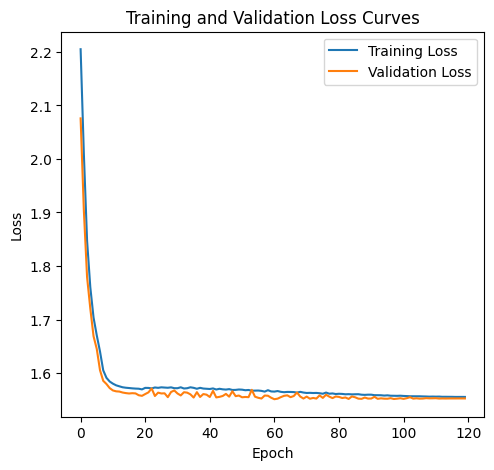

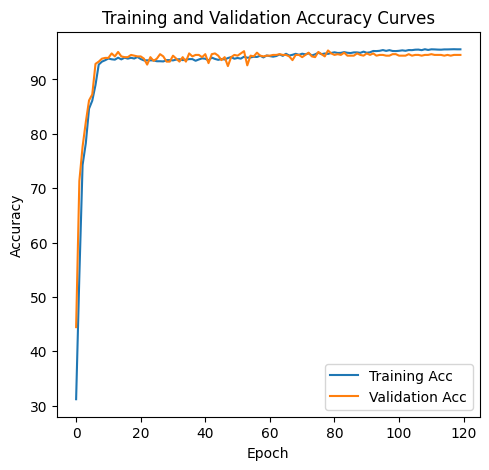

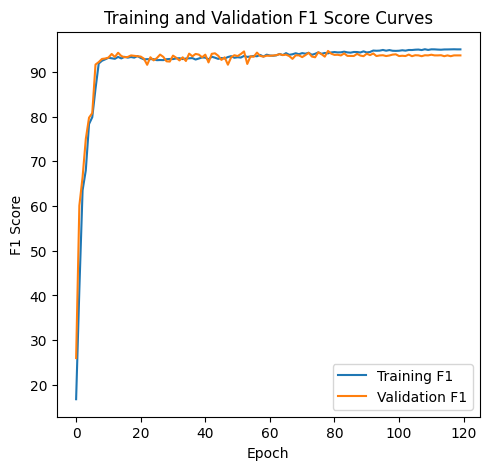

**********  Test  **********
Test Loss: 1.5607, Test Accuracy: 94.51%, Test F1: 93.88%
**********  Test.zip Prediction   **********
Net-1 save
********** Net-2 result **********
Epoch[1/120], Train Loss: 2.2956, Train Accuracy: 31.27%, Train F1: 25.63% | Valid Loss: 2.2818, Valid Accuracy: 48.15%, Valid F1: 35.08% | LR: 0.000042
Epoch[2/120], Train Loss: 2.1983, Train Accuracy: 33.43%, Train F1: 16.75% | Valid Loss: 2.0924, Valid Accuracy: 30.45%, Valid F1: 10.45% | LR: 0.000047
Epoch[3/120], Train Loss: 2.0451, Train Accuracy: 45.09%, Train F1: 28.02% | Valid Loss: 1.9612, Valid Accuracy: 55.42%, Valid F1: 34.95% | LR: 0.000056
Epoch[4/120], Train Loss: 1.9313, Train Accuracy: 56.37%, Train F1: 38.48% | Valid Loss: 1.8747, Valid Accuracy: 64.06%, Valid F1: 45.40% | LR: 0.000069
Epoch[5/120], Train Loss: 1.8594, Train Accuracy: 64.44%, Train F1: 48.02% | Valid Loss: 1.8115, Valid Accuracy: 70.23%, Valid F1: 54.14% | LR: 0.000085
Epoch[6/120], Train Loss: 1.7858, Train Accuracy: 73.10%,

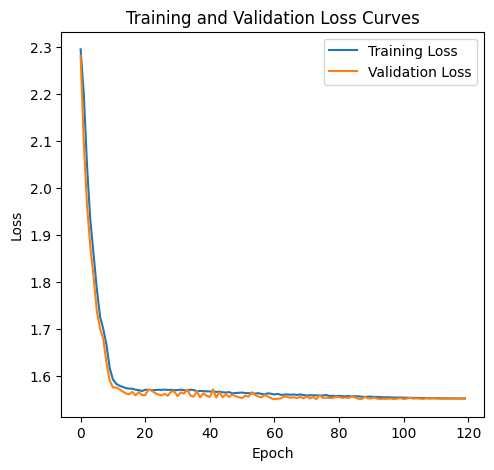

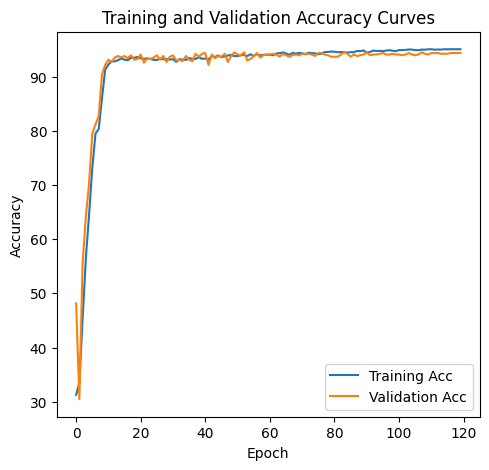

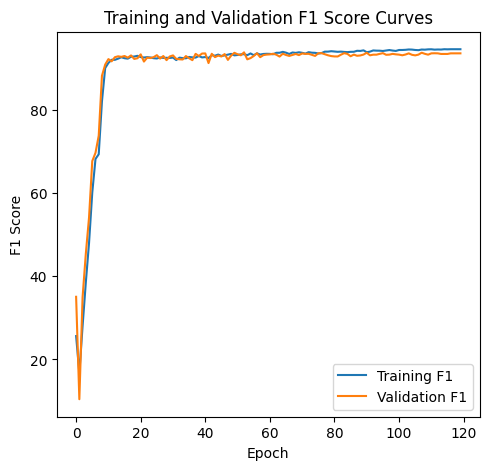

**********  Test  **********
Test Loss: 1.5571, Test Accuracy: 94.65%, Test F1: 94.04%
**********  Test.zip Prediction   **********
Net-2 save
********** Net-3 result **********
Epoch[1/120], Train Loss: 2.3027, Train Accuracy: 8.88%, Train F1: 1.79% | Valid Loss: 2.3027, Valid Accuracy: 9.74%, Valid F1: 1.77% | LR: 0.000042
Epoch[2/120], Train Loss: 2.3025, Train Accuracy: 8.95%, Train F1: 1.64% | Valid Loss: 2.3025, Valid Accuracy: 9.74%, Valid F1: 1.77% | LR: 0.000047
Epoch[3/120], Train Loss: 2.3023, Train Accuracy: 8.95%, Train F1: 1.64% | Valid Loss: 2.3024, Valid Accuracy: 9.74%, Valid F1: 1.77% | LR: 0.000056
Epoch[4/120], Train Loss: 2.3022, Train Accuracy: 8.95%, Train F1: 1.64% | Valid Loss: 2.3022, Valid Accuracy: 9.74%, Valid F1: 1.77% | LR: 0.000069
Epoch[5/120], Train Loss: 2.3020, Train Accuracy: 8.95%, Train F1: 1.64% | Valid Loss: 2.3020, Valid Accuracy: 9.74%, Valid F1: 1.77% | LR: 0.000085
Epoch[6/120], Train Loss: 2.3018, Train Accuracy: 8.95%, Train F1: 1.64% | Va

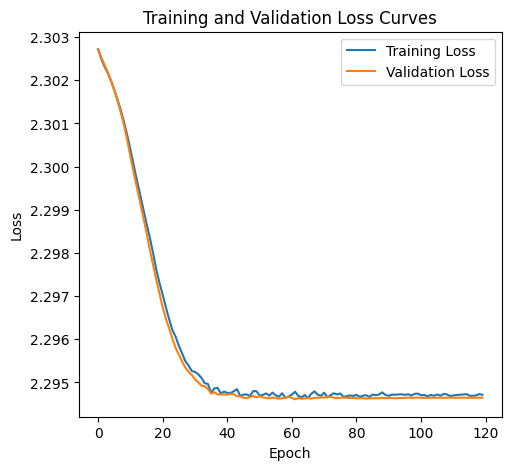

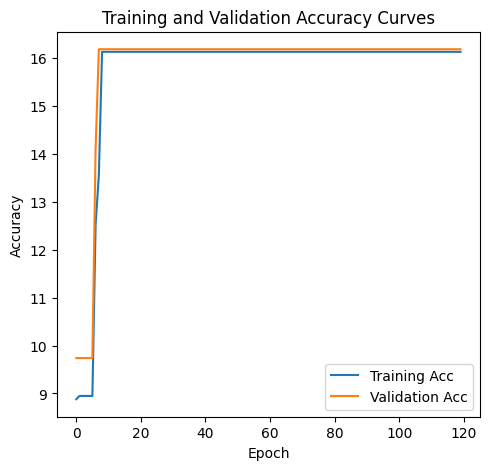

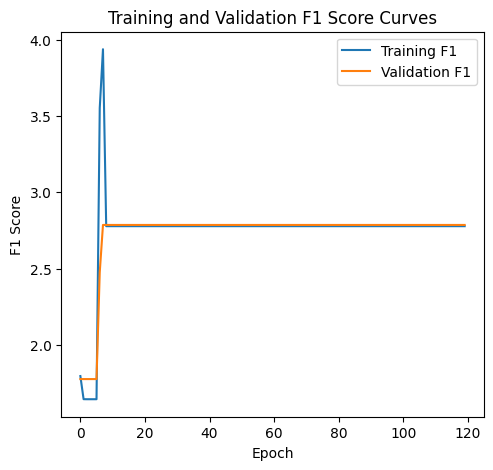

**********  Test  **********
Test Loss: 2.2917, Test Accuracy: 18.52%, Test F1: 3.12%
**********  Test.zip Prediction   **********
Net-3 save


In [20]:
def main():
    print("*"*10,"Net-1 result","*"*10)
    model =  SimpleNN(input_dim, hidden_dim, output_dim)
    modeling(model,"Net-1")
   
    
    print("*"*10,"Net-2 result","*"*10)
    model =  TwoHiddenLayerNN(input_dim, hidden_dim1, hidden_dim2, output_dim)
    modeling(model,"Net-2")
    
    print("*"*10,"Net-3 result","*"*10)
    model =  FourHiddenLayerNN(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim)
    modeling(model,"Net-3")
    

if __name__ == "__main__":
    main()